## Реализация и анализ авторегрессионной модели временного ряда

Целью данной лабораторной работы является реализация и анализ авторегрессионной модели
временного ряда AR(3). В ходе выполнения работы мы будем строить модель, проверять
стационарность временного ряда, генерировать новые значения, обучать модель машин опорных
векторов (SVR) и проводить анализ результатов.

Авторегрессионная (AR-) модель определяется следующим отношением:
$$X_t = c + \sum_{i=1}^p a_i X_{t-i}+ \varepsilon_t$$
Где:

$a_i$ - параметры модели (коэффициенты авторегрессии);

$\varepsilon_t$ - белый шум.

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Метод для создания последовательности векторов задержек
def create_lag_sequence(data, lag):
  X, y = [], []
  for i in range(len(data) - lag):
    X.append(data[i:i + lag])
    y.append(data[i + lag])
  return np.array(X), np.array(y)

In [ ]:
# Класс, реализующий авторегрессионную модель временного ряда AR(3)
class TimeSeriesARModel:
  def __init__(self, seed=42, n_obs=100, a0=2.0, a1=0.7, a2=-0.3, a3=0.5):
    np.random.seed(seed)
    self.n_obs = n_obs
    self.a0, self.a1, self.a2, self.a3 = a0, a1, a2, a3
    self.epsilon = np.random.normal(size=n_obs)
    self.xt = np.zeros(n_obs)

  # 1. Метод для генерации временного ряда по авторегрессионной модели
  def generate_ar_series(self):
    for t in range(3, self.n_obs):
      self.xt[t] = self.a0 + self.a1 * self.xt[t - 1] + self.a2 * self.xt[t - 2] + self.a3 * self.xt[t - 3] + self.epsilon[t]

  # Метод для построения графика временного ряда
  def plot_ar_series(self):
    plt.plot(self.xt)
    plt.title('AR(3) Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

  # 2. Метод для генерации временного ряда по авторегрессионной модели
  def check_stationarity(self):
    result = sm.tsa.adfuller(self.xt)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] < 0.05:
      print('Time series is stationary.')
    else:
      print('Time series is non-stationary.')

  # 3,4. Метод для генерации продолжения временного ряда
  def generate_extended_series(self, num_values=1000, scale=1.0):
    new_values = np.zeros(num_values)
    for t in range(3, num_values + 3):
      new_values[t - 3] = (self.a0 + self.a1 * new_values[t - 4] + self.a2 * new_values[t - 5] + self.a3 * new_values[t - 6] + np.random.normal(loc=0, scale=scale))
    plt.plot(np.concatenate((self.xt[:10], new_values)), label= 'Extended AR(3) Time Series')
    plt.title('Extended AR(3) Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

  # 5. Метод для обучения модели машин опорных векторов (SVR)
  def fit_svr_model(self, lag=3, test_size=0.2, kernel='linear', C=1.0, epsilon=0.1):
    X, y = create_lag_sequence(self.xt, lag)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    svr_model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    svr_model.fit(X_train, y_train)
    y_pred = svr_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error on Test Set: {mse}')
    print(f'AR Coefficients: {svr_model.coef_}')
    print(f'Intercept: {svr_model.intercept_}')
    plt.plot(y_test, label='True Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.legend()
    plt.title('SVR Regression for AR(3) Time Series')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

  # 6. Метод для построения графика сравнения оригинального и предсказанного временного ряда
  def plot_predicted_series(self, lag=3):
    predicted_values = np.zeros_like(self.xt)
    with warnings.catch_warnings():
      warnings.simplefilter("ignore", category=DeprecationWarning)
      for t in range(lag, len(predicted_values)):
        lagged_values = self.xt[t - lag:t][::-1]
        predicted_values[t] = self.a0 + np.dot([self.a1, self.a2, self.a3], lagged_values)
    plt.plot(self.xt, label='Original AR(3) Time Series')
    plt.plot(predicted_values, label='Predicted AR(3) Time Series')
    plt.title('Comparison of Original and Predicted AR(3) Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

  # 7. Метод для сравнения различных ядер и гиперпараметров модели SVR
  def compare_svr_kernels(self, lag=3, test_size=0.2, kernels=None, C_values=None, epsilon_values=None):
    if kernels is None:
      kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    if C_values is None:
      C_values = [0.1, 1, 10]
    if epsilon_values is None:
      epsilon_values = [0.01, 0.1, 0.2]
    X, y = create_lag_sequence(self.xt, lag)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    for kernel in kernels:
      for C in C_values:
        for epsilon_value in epsilon_values:
          svr_model = SVR(kernel=kernel, C=C, epsilon=epsilon_value)
          svr_model.fit(X_train, y_train)
          y_pred = svr_model.predict(X_test)
          mse = mean_squared_error(y_test, y_pred)
          print(f'For kernel={kernel}, C={C}, epsilon={epsilon_value}, MSE: {mse}')
          print(f'Intercept: {svr_model.intercept_}')

## Тесты

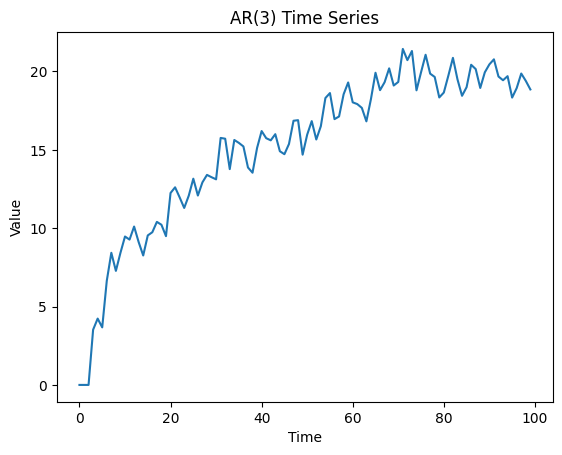

ADF Statistic: -3.415553040092043
p-value: 0.010439959055848696
Critical Values: {'1%': -3.5078527246648834, '5%': -2.895382030636155, '10%': -2.584823877658872}
Time series is stationary.
Mean Squared Error on Test Set: 0.9130204512168518
AR Coefficients: [[ 0.42043591 -0.25310123  0.7487766 ]]
Intercept: [1.49427928]


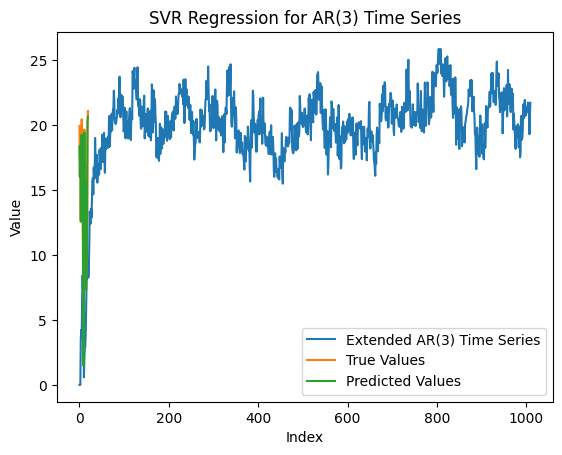

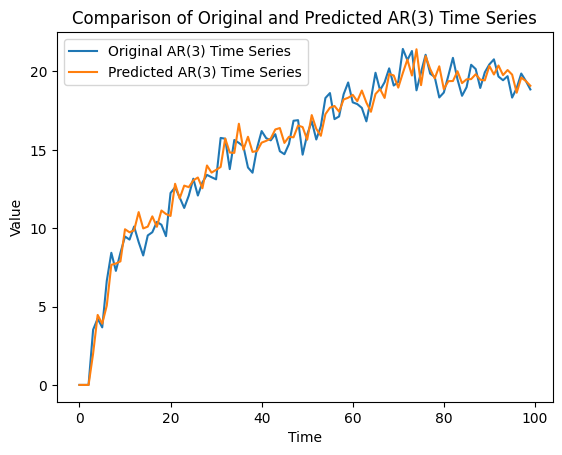

For kernel=linear, C=0.1, epsilon=0.01, MSE: 0.9211278064077953
Intercept: [1.56488038]
For kernel=linear, C=0.1, epsilon=0.1, MSE: 0.9460077430180066
Intercept: [1.53834776]
For kernel=linear, C=0.1, epsilon=0.2, MSE: 0.8935289620943184
Intercept: [1.71294382]
For kernel=linear, C=1, epsilon=0.01, MSE: 0.9338936833495015
Intercept: [1.39542282]
For kernel=linear, C=1, epsilon=0.1, MSE: 0.9130204512168518
Intercept: [1.49427928]
For kernel=linear, C=1, epsilon=0.2, MSE: 0.8674426146085068
Intercept: [1.58169456]
For kernel=linear, C=10, epsilon=0.01, MSE: 0.9326387000120346
Intercept: [1.39708494]
For kernel=linear, C=10, epsilon=0.1, MSE: 0.9178076291563684
Intercept: [1.45689541]
For kernel=linear, C=10, epsilon=0.2, MSE: 0.869617751732843
Intercept: [1.57296818]
For kernel=poly, C=0.1, epsilon=0.01, MSE: 3.4095564861392544
Intercept: [9.33239594]
For kernel=poly, C=0.1, epsilon=0.1, MSE: 3.415542550309327
Intercept: [9.35434877]
For kernel=poly, C=0.1, epsilon=0.2, MSE: 3.4852999498

In [ ]:
ar_model = TimeSeriesARModel()
ar_model.generate_ar_series()
ar_model.plot_ar_series()
ar_model.check_stationarity()
ar_model.generate_extended_series()
ar_model.fit_svr_model()
ar_model.plot_predicted_series()
ar_model.compare_svr_kernels()